# Class Activation Map 만들기

### CAM(Class Activation Map)
---
- 클래스에 대한 활성화 정도를 나타낸 지도
- 특성을 추출하는 CNN네트워크 뒤에 GAP(Gloval Average Pooling)와 소프트맥스 레이어(softmax layer)rk 붙는 형태로 구성되어야 하는 제약

### Grad-CAM
- 추가적인 조건이 필요하지 않으므로 CAM모델을 이용한 것

### CAM or Grad-CAM을 하기 위한 모델 조건
- 분류(classfication)을 수행하는 모델
- 위치 정보가 기록된 데이터가 필요
    - 이미지 내에서 클래스가 활성화 된 위치를 확인하고 정답과 비교하는 것이 목표
    
###  Tensorflow Datasets의 카달로그에 있는 'standford_dogs' 데이터셋 사용
- 120여 개의 개를 사진으로 판별하는 분류 문제 데이터셋
- 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있다.
-[stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

## Step 0. 필요한 라이브러리 불러오기

In [1]:
# Tensorflow...
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# He;per livraries
import numpy as np
import pandas as np
import matplotlib.pyplot as plt

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 1.  데이터셋 준비하기

### 1.1 'stanford_dogs' 데이터셋 다운로드
- 학습용 데이터 12,000장, 평가용 데이터셋 8,580장으로 구성
- tfds.load()를 이용해 데이터셋 다운로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

#### 데이터셋 기본정보확인

#### 1.1 tfds.show_examples()를 이용해서 이미지의 클래스, 인덱스 확인

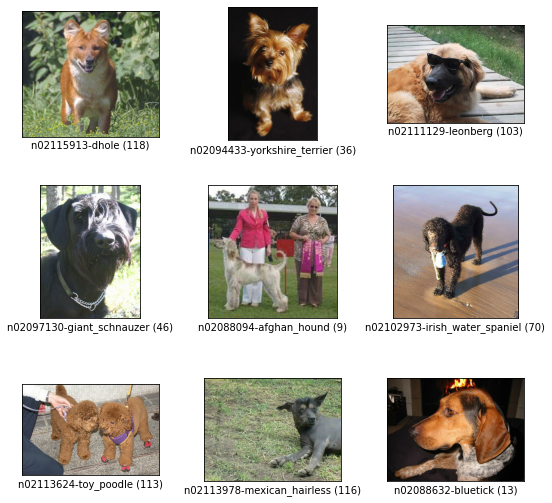

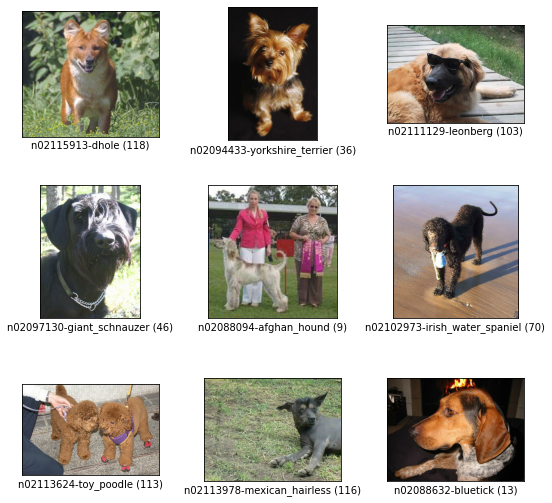

In [4]:
# ts_train
tfds.show_examples(ds_train, ds_info)

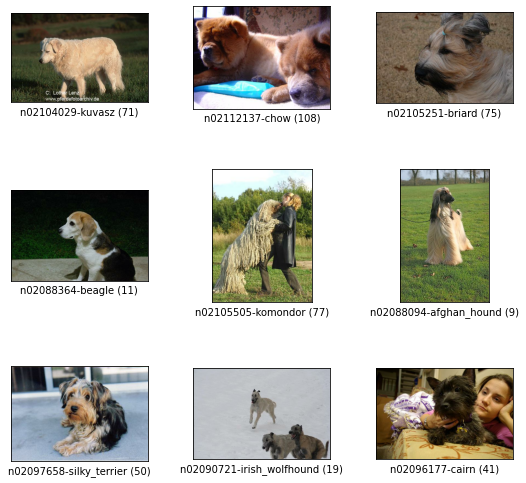

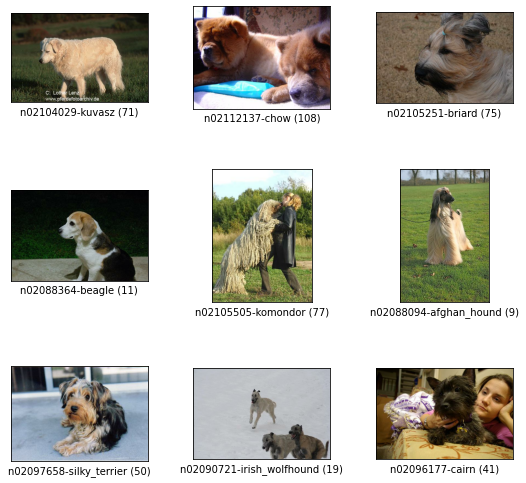

In [5]:
# ds_test
tfds.show_examples(ds_test, ds_info)

## Step 2. 물체의 위치정보

- 원본 이미지 위의 물체의 위치정보를 어떻게 시각화 할 수 있을까??
<br>

### 2.1 FeaturesDict
- image : 입력이미지, label : 이미지의 정답 클래스의 인덱스
- bbox(바운딩박스) : 물체의 위치를 사각형 영역으로 표기하는 방법
    - BBoxFeature타입으로 정의
    
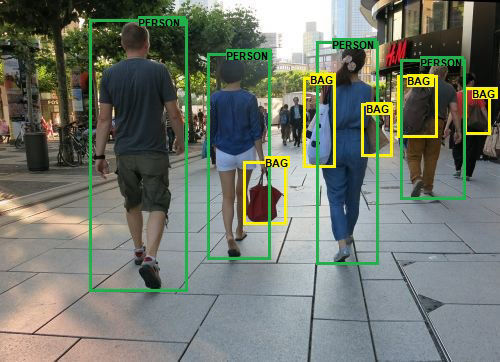

In [6]:
# df_info의 features정보 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### 2.2 바운딩 박스를 표시하는 방법들
---
#### 'xywh' 
- 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법
    - 예) (x_center, y_center, width, height)
        - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다.

<br>

#### 'minmax'
- 바운딩박스를 이루는 좌표의 최소값, 최대값을 통해 표기하는 방법
    - 예) (x_min, x_max, y_min, y_max)
        - 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기
        
<br>

#### 그 외의 바운딩 박스 라벨링 하는 방법  
- 이미지의 상하좌우 끝단으로부터 거리를 표현하는 방법
- 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB)
- 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD)
    
- **[Tensorflow BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)**

**Q1. 주어진 데이터셋에서 `BBoxFeature` 타입으로 표기된 `bbox` 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요? 위에 제시된 텐서플로우 튜토리얼 링크를 통해 확인해 봅시다.**

- **해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.**

## Step 3. CAM을 위한 모델 만들기
- ResNet50을 기반으로 pooling layer뒤에 소프트맥스 레이어를 붙여 CAM모델 만들기
- 소프트맥스 레이어 - 소프트맥스 함수를 활성화 함수로 사용하는 fully connected layer

### 3.1 CAM모델 구현
- fully connected layer 대신 GAP을 사용해 주어야 한다.
- ResNet50의 매개변수 pooling에 'avg' 매개변수를 전단해 GAP연산을 붙이기

In [7]:
# CAM 모델 구현
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

x = base_model.output

preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**Q2. CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.**

- **conv5_block3_out의 output이 feature map이 됩니다.**

## Step 4. CAM 모델 학습하기

- 학습 데이터, 검증데이터
- bbox 정보가 포함되어 있지만 bounding box 같은 직접적인 라벨을 사용하지 않고 `weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식`이기 때문

In [9]:
# 전처리
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
# cb = keras.callbacks.ModelCheckpoint('best_cam_model.h5')
# es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [13]:
# 모델 훈련
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
#     callbacks=[cb, es]
)

Epoch 1/20
750/750 [==============================] - 169s 212ms/step - loss: 2.2141 - accuracy: 0.4433 - val_loss: 3.4513 - val_accuracy: 0.2125
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 0.6922 - accuracy: 0.8069 - val_loss: 1.2389 - val_accuracy: 0.6379
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2273 - accuracy: 0.9542 - val_loss: 1.0848 - val_accuracy: 0.6867
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0941 - accuracy: 0.9889 - val_loss: 0.9305 - val_accuracy: 0.7360
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0347 - accuracy: 0.9969 - val_loss: 0.9387 - val_accuracy: 0.7436
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0176 - accuracy: 0.9995 - val_loss: 0.9364 - val_accuracy: 0.7450
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0137 - accuracy: 0.9998 - val_loss: 0.9469 -

In [14]:
# 학습 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_20.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


## Step 6. CAM

- 커널 재사용 권장

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


### 6.1 CAM 생성 준비1
- 배치단위가 아닌 이미지 한 장씩 적용하므로 한 장씩 가져오기 세팅

In [2]:
# 이미지 한 장씩 가져오는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

71


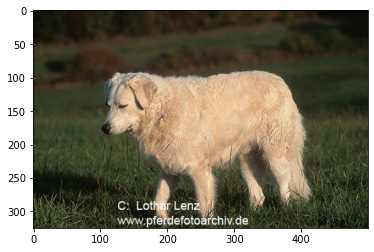

In [3]:
# 이미지 한 장씩 가져와서 출력
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 6.2 학습한 모델 불러오기

In [4]:
# CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_20.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### 6.3 CAM 생성조건
- (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치 (3) 원하는 클래스의 출력값이 필요
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 `CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화`
- model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들기

#### generate_cam() 
- conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 `새로운 모델을 정의`
- feedforward를 거친 후 CAM을 계산하도록 구현
- 입력 이미지의 크기에 맞춰 CAM을 resize

In [5]:
# CAM 생성조건 맞추기 위한 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져오기
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

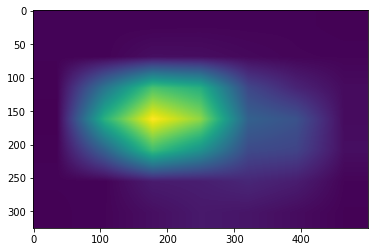

In [6]:
# generate_cam()를 이용해 CAM 생성,출력
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### 6.4 원본 이미지와 CAM이미지 합성

In [7]:
# CAM 이미지를 원본 이미지와 합치는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

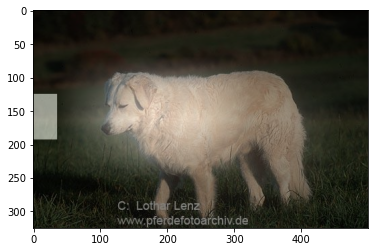

In [8]:
# CAM 이미지를 원본 이미지와 합쳐서 출력
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Step 7. Grad-CAM

- 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상을 활용해 관찰 대상 모델은 cam_model을 그대로 활용

108


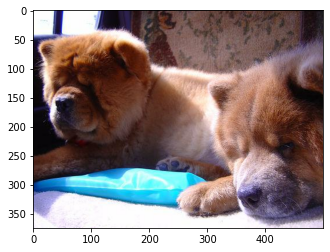

In [9]:
# 새로운 이미지를 가져오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 7.1 **Grad-CAM을 이용해서 CAM을 만드는 과정**

- **관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트에 GAP 연산을 적용해서 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다.**
- **레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됩니다.**

**Grad-CAM의 장점**

- **어떤 레이어든 CAM 이미지를 뽑아낼 수 있다,**
- **그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용**

In [10]:
"""generate_grad_cam()에서는 원하는 레이어의 output과 
특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용"""

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻기.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻기

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구하기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 7.2 **`generate_grad_cam()`로 여러 레이어의 CAM 이미지를 뽑아서 출력**

- **레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있다.**

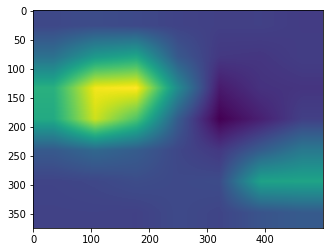

In [11]:
# generate_grad_cam()로 conv5_block3_out의 CAM 이미지를 뽑아서 출력
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

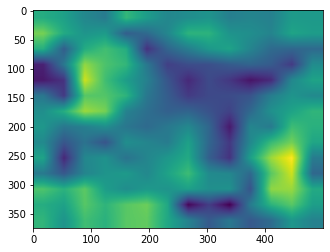

In [12]:
# generate_grad_cam()로 conv4_block3_out의 CAM 이미지를 뽑아서 출력
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

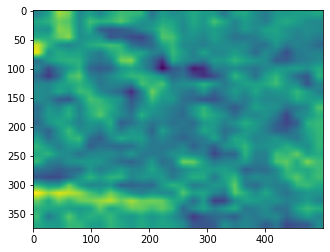

In [13]:
# generate_grad_cam()로 conv3_block3_out의 CAM 이미지를 뽑아서 출력
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Step 8. Detection with CAM

### 8.1 바운딩 박스

- CAM에서 물체의 위치를 찾는 detection



#### generate_cam()을 활용해서 CAM 이미지 생성, 출력

116


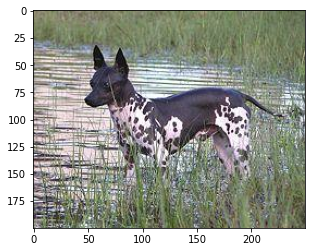

In [14]:
# ds_test에서 이미지 한 개 가져오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

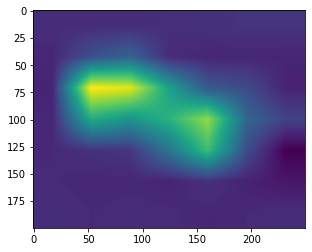

In [15]:
# 활성화 이미지 얻기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

#### **`get_bbox()` 함수**

- **바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스 제거**
- **OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾기**
- **`rotated_rect` 라는 회전된 바운딩 박스 획득**
- **`boxPoints()`로 이를 꼭지점으로 바꾸어 주기**
- **`int` 자료형으로 변환**

In [16]:
# 바운딩 박스 생성 함수
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [17]:
# cam_image를 통해 bbox를  구하기
rect = get_bbox(cam_image)
rect

array([[  2, 113],
       [ 38,   0],
       [259,  72],
       [223, 184]])

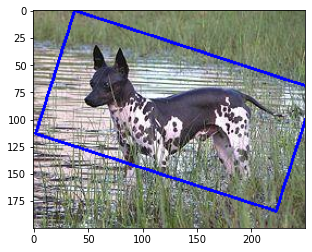

In [18]:
# 이미지에 바운딩 박스 적용
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### 8.2 Intersection Over Union

- 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가하는 방법
- 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값
- 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.



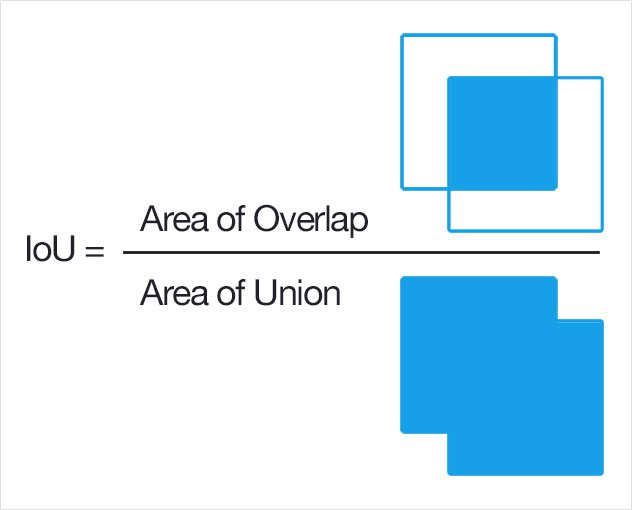

In [19]:
# rect를 이용해 bbox의 출력 형태 변경하는 함수
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [20]:
# rect를 rect_to_minmax() 함수를 활용해 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.008, 0.92, 1.036]

In [21]:
# 원본 이미지에 있는 bbox 좌표 가져오기
item['objects']['bbox'][0]

array([0.165, 0.192, 0.8  , 0.924], dtype=float32)

In [22]:
# IoU계산하는 함수
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [23]:
# IoU 값 구하기
get_iou(pred_bbox, item['objects']['bbox'][0])

0.49147775074972194

## Step 9. 성능비교

100


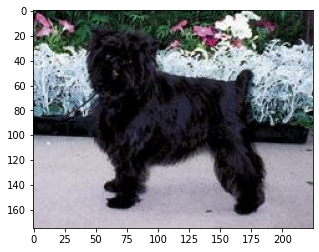

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 9.1 CAM

In [25]:
cam_image = generate_cam(cam_model, item)

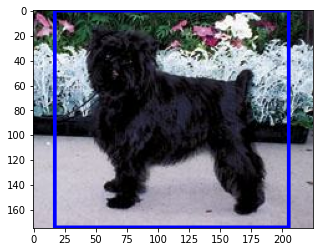

In [26]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [27]:
pred_box = rect_to_minmax(rect, item['image'])
cam_iou = get_iou(pred_box, item['objects']['bbox'][0])
cam_iou

0.7062851740368481

### 9.2 Grad_CAM

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

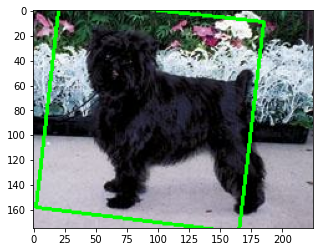

In [29]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image, [rect_g], 0, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [30]:
pred_bbox_g = rect_to_minmax(rect_g, item['image'])
iou_g = get_iou(pred_bbox_g, item['objects']['bbox'][0])
iou_g

0.6458985568061903

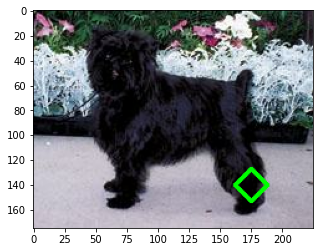

In [31]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv5_block2_out', item)

image = copy.deepcopy(item['image'])
rect_g2 = get_bbox(grad_cam_image2)

image = cv2.drawContours(image, [rect_g2], 0, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [32]:
pred_bbox_g2 = rect_to_minmax(rect_g2, item['image'])
iou_g2 = get_iou(pred_bbox_g2, item['objects']['bbox'][0])
iou_g2

0.029259001993659117

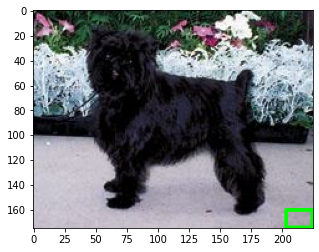

In [33]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv5_block1_out', item)

image = copy.deepcopy(item['image'])
rect_g3 = get_bbox(grad_cam_image3)

image = cv2.drawContours(image, [rect_g3], 0, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [34]:
pred_bbox_g3 = rect_to_minmax(rect_g3, item['image'])
iou_g3 = get_iou(pred_bbox_g3, item['objects']['bbox'][0])
iou_g3

0.0

In [35]:
type(cam_iou)

numpy.float64

In [36]:
import pandas as pd
data = {'CAM' : cam_iou,
       'Grad conv5_block3_out' : iou_g,
       'Grad conv5_block2_out' : iou_g2,
       'Grad conv5_block1_out' : iou_g3}
iou_df = pd.DataFrame(data, index=['iou'])
iou_df

,CAM,Grad conv5_block3_out,Grad conv5_block2_out,Grad conv5_block1_out
iou,0.706285,0.645899,0.029259,0.0


- Grad-CAM모델이 잘 나올거라고 생각했는데 CAM모델이 더 잘 나왔다.
- Gard-CAM모델의 iou는 불안정해서.. 여러군데를 해 봐야 할 것 같다..

## 회고
- 이번 프로젝트에서 **어려웠던 점**
    - 그냥 노드를 그대로 프로젝트에 반영해서 어려운 것은 없었다.
- 프로젝트를 진행하면서 **알아낸 점
    - CAM, Grad-CAM을 이용해서 디텍션이 가능하다.
- 프로젝트를 진행하면서 **아직 모호한 점**
    - 나름 훈련한다고 했는 데, iou점수가 좋지 않다... 왜 그럴까??
    - 에포크를 더하면 괜찮아질까??
    - bbox바꾸는 것이 아직 어렵다..

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**
    - 생각보다 iou점수가 안 나와서 callback클래스를 이용해서 좋은 모델을 저장했는 데, 아닌 것으로 해봐야겠다.